In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product, islice
import h5py
import random

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [3]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [4]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [14]:
class RewardDataRandomized(th.utils.data.Dataset):
    def __init__(self, train=True):
        self.f = h5py.File(f"../datasets/rewards_{env_id}.hdf5", 'r')
        if train:
            self.group = self.f['train']
        else:
            self.group = self.f['test']
        self.length = self.group['ones-labels'].shape[0] + self.group['zeros-labels'].shape[0]
        self.labels = th.randint(low=0, high=2, size=(self.length, 1)).to(dtype)
        
    
    def __getitem__(self, k):
        if k % 2 == 0:
            input = self.group['zeros-inputs'][k // 2]
            label = self.labels[k // 2]
            return (input, label)
        else:
            input = self.group['ones-inputs'][k // 2]
            label = self.labels[k // 2]
            return (input, label)
    
    def __len__(self):
        return self.length
    
    def close(self):
        self.f.close()
        
class RewardNet(nn.Module):
    def __init__(self):
        self.layer1 = nn.Linear(512, 512)
        self.layer2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = nn.ReLU(self.layer1(x))
        return self.layer2(x)
        
class RewardModelBigger(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = RewardNet().to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [15]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()
def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()


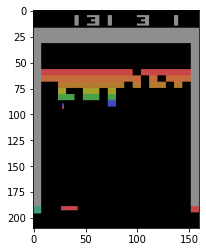

In [16]:
obs = env.reset()
for i in range(600):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

plt.imshow(env.get_images()[0])

# Train a reward model on random labels

In [17]:
train = RewardDataRandomized(train=True)
test = RewardDataRandomized(train=False)

train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

In [18]:
rm = RewardModel(env, device)

optimizer = th.optim.Adam(rm.parameters())
loss_fn = th.nn.MSELoss()
loss_fn_sum = th.nn.MSELoss(reduction="sum")

In [19]:
for epoch in tqdm(range(5)):
    for samples, targets in train_loader:
        optimizer.zero_grad()
        batch_loss = loss_fn(rm(samples), targets.to(device))
        batch_loss.backward()
        optimizer.step()
    outof = 0
    training_loss = 0
    with th.no_grad():
        for samples, target in islice(train_loader, 500):
            training_loss += loss_fn_sum(rm(samples), targets.to(device))
            outof += len(target)
    training_loss = float(training_loss / outof)
    print("Training Loss: {:.5f}".format(training_loss))
    outof = 0
    testing_loss = 0
    with th.no_grad():
        for samples, target in islice(test_loader, 500):
            testing_loss += loss_fn_sum(rm(samples), targets.to(device))
            outof += len(target)
    testing_loss = float(testing_loss / outof)
    print("Testing Loss: {:.5f}\n".format(testing_loss))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training Loss: 0.25117
Testing Loss: 0.25117

Training Loss: 0.24750
Testing Loss: 0.24750

Training Loss: 0.25125
Testing Loss: 0.25125

Training Loss: 0.25015
Testing Loss: 0.25015

Training Loss: 0.25074
Testing Loss: 0.25074




# Okay screw it -- too hard to train on random labels. Let's just do sanity check number 1

In [20]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def forward_tensor(self, obs):
        """obs is a tensor which has already been transposed correctly."""
        latent, _, _= self.ac_model._get_latent(obs.to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [31]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

In [32]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

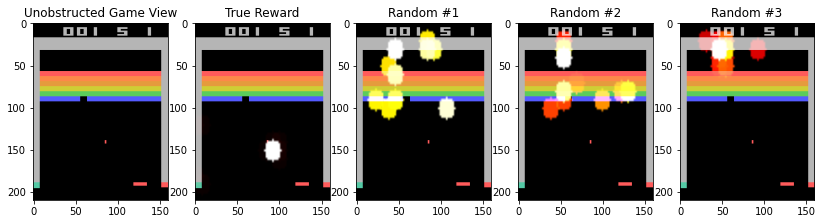

In [34]:
radius = 5
stride = 4

TIMESTEPS = 50

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Can you tell which is best?", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=6, metadata=metadata)

fig, (axes) = plt.subplots(1, 5, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]}, figsize=(14, 5))
axes[0].set_title("Unobstructed Game View")
axes[1].set_title("True Reward")
for k in range(3):
    axes[k+2].set_title(f"Random #{k+1}")
frames = [ax.imshow(env.get_images()[0]) for ax in axes]

models = []
for k in range(3):
    random_model = RewardModel(env, device)
    models.append(random_model)

obs = env.reset()
with writer.saving(fig, "../videos/breakout/breakout-occlusion-sanity-check.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        screenshot_baseline = env.get_images()[0]
        frames[0].set_data(screenshot_baseline / screenshot_baseline.max())
        
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = np.copy(screenshot_baseline)
        screenshot = screenshot / screenshot.max()
        max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        frames[1].set_data(screenshot)
        
        for k in range(3):
            pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(models[k], obs, e, radius=radius))
            screenshot = np.copy(screenshot_baseline)
            screenshot = screenshot / screenshot.max()
            max_value = pairs[0][1]
            for loc, value in pairs:
                r, g, b, a = matplotlib.cm.hot(value / max_value)
                region = create_circular_mask(84, 84, center=loc, radius=radius)
                region = skimage.transform.resize(region, (210, 160))
                spot = np.zeros((210, 160, 3))
                spot[:, :, 0] = r * region
                spot[:, :, 1] = g * region
                spot[:, :, 2] = b * region
                spot = spot * a
                screenshot = spot + (1-spot)*screenshot
                screenshot = screenshot / screenshot.max()
            frames[k+2].set_data(screenshot)
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)